In [3]:
# import packages
# matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

#ustawiam ziarno pseudolosowania i udział zbioru testowego
RANDOM_SEED = 128262 
TEST_PCT = 0.2 

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # złoty podział
LABELS = ["Normal","Fraud"]

In [4]:
df = pd.read_csv("creditcard.csv")

In [5]:
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75)
sns.set_palette(sns.xkcd_palette(col_list))

Normalize and Scale Data

In [6]:
df_norm = df.copy()
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature
# or array.reshape(1, -1) if it contains a single sample.
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

Dividing Training and Test Set

In [7]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0]       # where normal transactions
train_x = train_x.drop(['Class'], axis=1)   # drop the class column


test_y = test_x['Class']                    # save the class column for the test set
test_x = test_x.drop(['Class'], axis=1)     # drop the class column

train_x = train_x.values                    # transform to ndarray
test_x = test_x.values                      # transform to ndarray

In [11]:
df_norm.shape

(284807, 31)

Creating The Mode

In [8]:
# Autoencoder Layer Structure and Parameters

nb_epoch = 50
batch_size = 64
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 20
hidden_dim1 = 12 #int(encoding_dim / 2) #i.e. 7
hidden_dim2 = 6
learning_rate = 1e-7

In [9]:
# This returns a tensor
input_layer = Input(shape=(input_dim, ))

# a layer instance is callable on a tensor, and returns a tensor
# Dense implements the operation: output = activation(dot(input, kernel) + bias), where
# activation is the element-wise activation function passed as the activation argument, 
# kernel is a weights matrix created by the layer, and 
# bias is a bias vector created by the layer (only applicable if use_bias is True).

# activity_regularizer: Regularizer function applied to the output of the layer
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim1, activation="relu")(encoder)
encoder = Dense(hidden_dim2, activation="relu")(encoder)
decoder = Dense(hidden_dim2, activation='relu')(encoder)
decoder = Dense(hidden_dim1, activation='relu')(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)

# This creates a model that includes
# the Input layer and four Dense layers
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [10]:
# Configure the learning process, by compiling the model
autoencoder.compile(optimizer='adam',
                    metrics=['accuracy'],
                    loss='mean_squared_error')

# Saving the model
cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                     save_best_only=True,
                     verbose=0)

# TensorBoard basic visualizations.
# This callback writes a log for TensorBoard, 
# which allows you to visualize dynamic graphs of your training and test metrics
tb = TensorBoard(log_dir='./logs',
                 histogram_freq=0,
                 write_graph=True,
                 write_images=True)

# Starts training
# autoencoder: same training(x) and target data(y)
# validation_data: tuple (x_val, y_val) on which 
# to evaluate the loss and any model metrics at the end of each epoch.

# History.history attribute is a record of training loss values 
# and metrics values at successive epochs.
history = autoencoder.fit(x=train_x, y=train_x,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(test_x, test_x),
                          verbose=1,
                          callbacks=[cp, tb]).history

Epoch 1/50
3554/3554 [==============================] - 4s 905us/step - loss: 0.8441 - accuracy: 0.4969 - val_loss: 0.8290 - val_accuracy: 0.5709
Epoch 2/50
3554/3554 [==============================] - 3s 854us/step - loss: 0.7868 - accuracy: 0.5795 - val_loss: 0.8101 - val_accuracy: 0.5818
Epoch 3/50
3554/3554 [==============================] - 3s 851us/step - loss: 0.7734 - accuracy: 0.5926 - val_loss: 0.8002 - val_accuracy: 0.6046
Epoch 4/50
3554/3554 [==============================] - 3s 856us/step - loss: 0.7608 - accuracy: 0.6199 - val_loss: 0.7896 - val_accuracy: 0.6282
Epoch 5/50
3554/3554 [==============================] - 3s 874us/step - loss: 0.7542 - accuracy: 0.6282 - val_loss: 0.7834 - val_accuracy: 0.6312
Epoch 6/50
3554/3554 [==============================] - 3s 883us/step - loss: 0.7501 - accuracy: 0.6298 - val_loss: 0.7802 - val_accuracy: 0.6345
Epoch 7/50
3554/3554 [==============================] - 3s 870us/step - loss: 0.7474 - accuracy: 0.6332 - val_loss: 0.7770 -

In [11]:
autoencoder = load_model('autoencoder_fraud.h5')

Model Evaluation

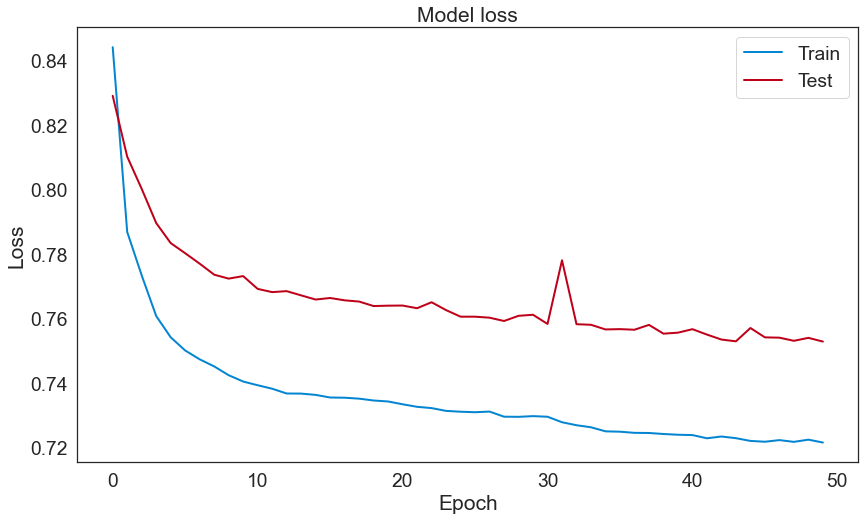

In [12]:
plt.figure(figsize=(14, 8))
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

Reconstruction Error Check

In [13]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.752861,0.001668
std,3.264963,0.040805
min,0.050119,0.000000
25%,0.266773,0.000000
50%,0.427377,0.000000
75%,0.687135,0.000000
max,387.642157,1.000000


ROC Curve Check

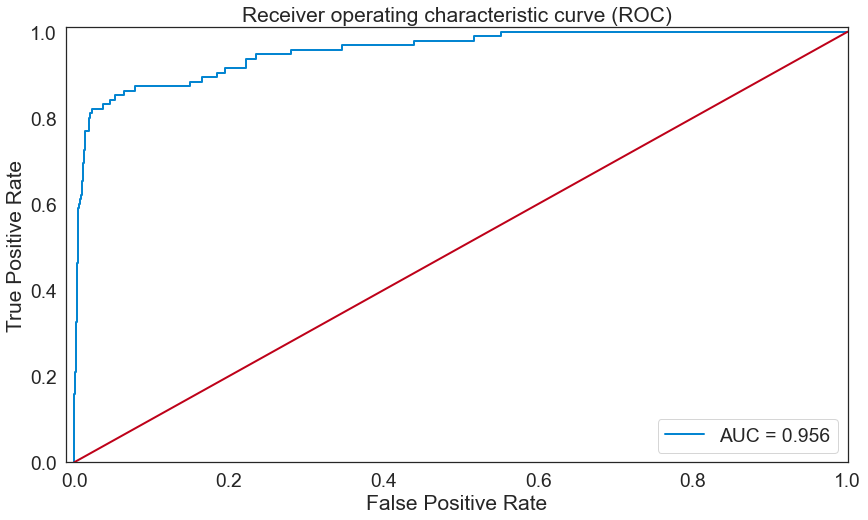

In [14]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class,
                                                      error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.figure(figsize=(14, 8))
plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=2)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Recall vs. Precision Thresholding

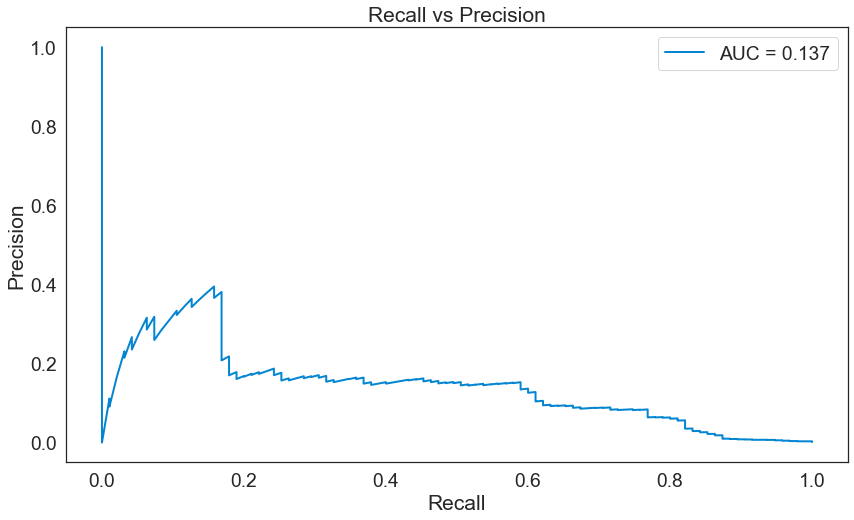

In [15]:
# calculates precision/recall using reconstruction error as the decision function
# returns: 
# precision_rt: Precision values such that element i is the precision of predictions with 
#               score >= thresholds[i] and the last element is 1.
# recall_rt: Decreasing recall values such that element i is the recall of predictions with 
#           score >= thresholds[i] and the last element is 0.
# threshold_rt = Increasing thresholds on the decision function used to compute
#                precision and recall.
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class,
                                                               error_df.Reconstruction_error)

pr_auc = auc(recall_rt, precision_rt,)

plt.figure(figsize=(14, 8))
plt.plot(recall_rt, precision_rt, linewidth=2, label='AUC = %0.3f'% pr_auc)
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

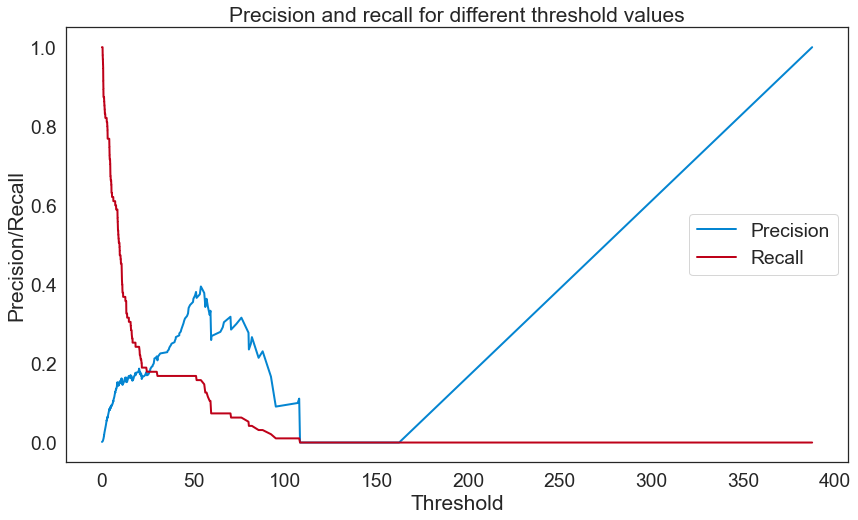

In [16]:
plt.figure(figsize=(14, 8))
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=2)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=2)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Reconstruction Error vs Threshold Check

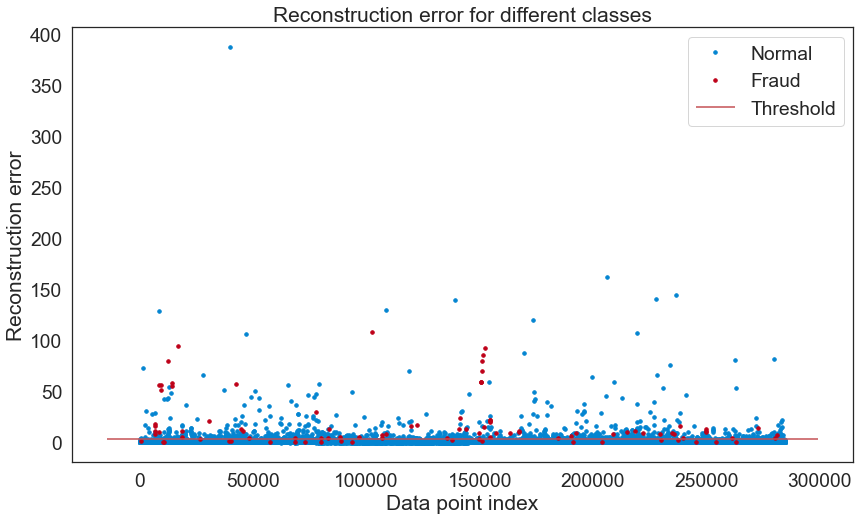

In [17]:
threshold_fixed = 4
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(14, 8))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1],
          colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

Confusion Matrix

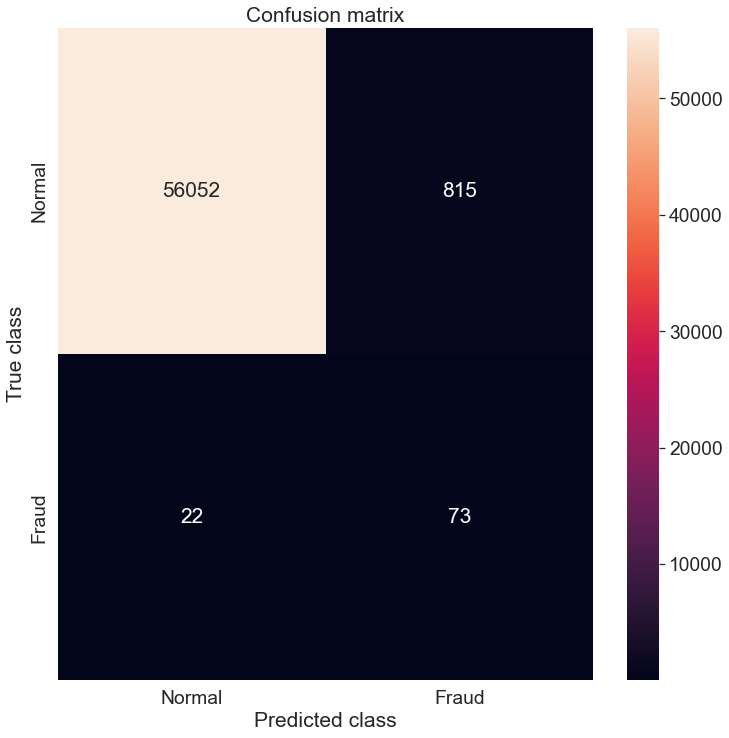

In [18]:
 #As with autoencoders, it is the assumption that fraud or anomalies will suffer 
# from a detectably high reconstruction error, predicting class as 1 (Fraud)
# if reconstruction error is greater than threshold
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()